In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Note EWKino_CLs_train.csv and EWKino_CLs_test.csv are already normalised to mean=0 and std=1 on every column that isn't CLs
df = pd.read_csv("../csv-files/Bino-DM-norm-inputs-train.csv")
input_parameters = ['M_1', 'M_2', 'mu', 'tan_beta', 'M_3', 'At', 'Ab', 'Atau', 'mA', 'mqL3', 'mtR', 'mbR']

#CLs_labels = ['FullHad', '1Lbb', '2L0J', '2L2J', 'Compressed', '3LOffshell', '3LOnshell', '4L', 'DisappearingTrack', 'h_to_inv', 'mA']
#CLs_labels = [label+'__ObsCLs' for label in CLs_labels]
#CLs_labels.append("Final__CLs")
chosen_CLs = 'Final__CLs'

training_cols = input_parameters
training_cols.append(chosen_CLs)

train = df[training_cols]
train.head()

2025-03-21 17:47:15.288098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 17:47:15.660718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-21 17:47:16.711828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,M_1,M_2,mu,tan_beta,M_3,At,Ab,Atau,mA,mqL3,mtR,mbR,Final__CLs
0,-1.215815,-0.687340,0.792771,1.089163,1.219405,-1.001609,-1.443290,0.756117,-1.195757,-1.721317,-0.052403,-1.362423,3.620000e-01
1,0.480107,0.248363,0.251134,1.001881,0.458560,-1.421324,-1.564870,-0.299685,1.524168,0.212202,1.146116,1.483333,3.710000e-04
2,0.085638,-0.374153,-0.295689,1.538541,-1.469366,-1.448066,0.623688,-0.629610,-0.099472,-0.382823,1.098888,-1.010809,2.930000e-05
3,1.033566,1.839255,-0.386771,-1.481458,-0.853338,-1.050916,-1.454962,1.073570,1.363035,0.604817,-0.035111,0.542336,7.670000e-01
4,0.147125,-0.199771,0.374328,-0.929173,-1.567551,0.774706,0.829474,0.222086,1.785433,-0.868240,1.389270,0.985923,3.530000e-11


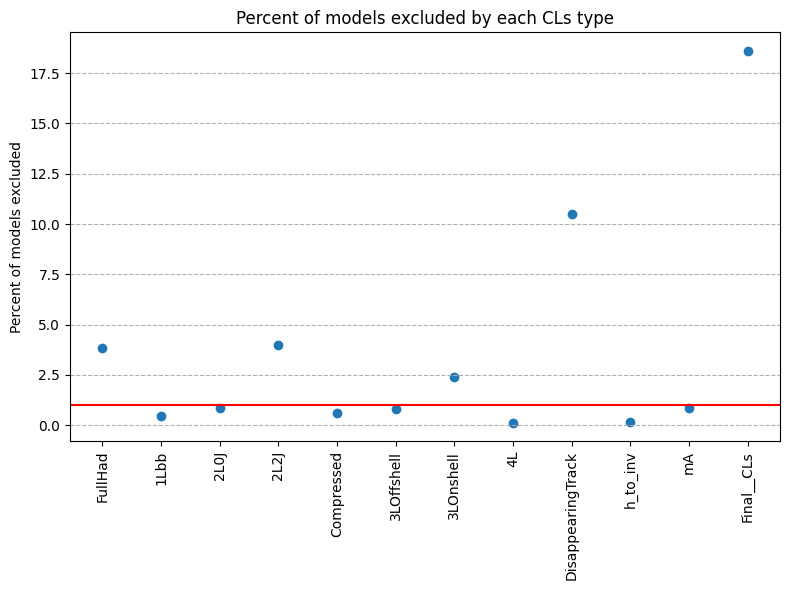

In [7]:
exclusion_per_CLs = []
for CLs in CLs_labels:
    total_exclusions = (df[CLs] < 0.05).sum()
    frac_excluded = 100 * total_exclusions / 10438
    exclusion_per_CLs.append(frac_excluded)

plt.figure(figsize=(8,6))
x_labels = [label[:-8] for label in CLs_labels]
x_labels[-1] = 'Final__CLs'
plt.scatter(x_labels, exclusion_per_CLs)
plt.xticks(rotation = 90)
plt.grid(axis='y', linestyle='--')
plt.ylabel('Percent of models excluded')
plt.title('Percent of models excluded by each CLs type')
plt.axhline(1, color='red')
plt.tight_layout()

In [3]:
def neg_linear_loss(y_true, y_pred):

    # Calculate absolute error for each prediction
    abs_error = tf.abs(y_true - y_pred)
    
    # Weight to focus on values close to zero
    weighted_error = abs_error * (1 + (1 - y_true))

    # Return weighted MAE as loss
    loss = tf.reduce_mean(weighted_error)
    return loss

def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.005),
        loss='mae',
        metrics=["mae"]
    )
    
    return model

In [14]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    # Shuffle the entire training dataset
    shuffled_df = df.sample(frac=1)
    
    # Separate the inputs and target outputs into train and labels respectively
    labels = shuffled_df.pop(chosen_CLs)
    train = shuffled_df
    num_val_samples = len(train) // k
    if k == 1:
        num_val_samples = len(train) // 5
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [15]:
# Choose number of folds for k-fold validation, number of epochs, and iterations
k = 1
num_epochs = 60 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 5 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)

# avg_train_accuracy and avg_val_accuracy store the training and validation accuracy for each epoch, averaged over the k folds
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    #print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, train)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
    
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

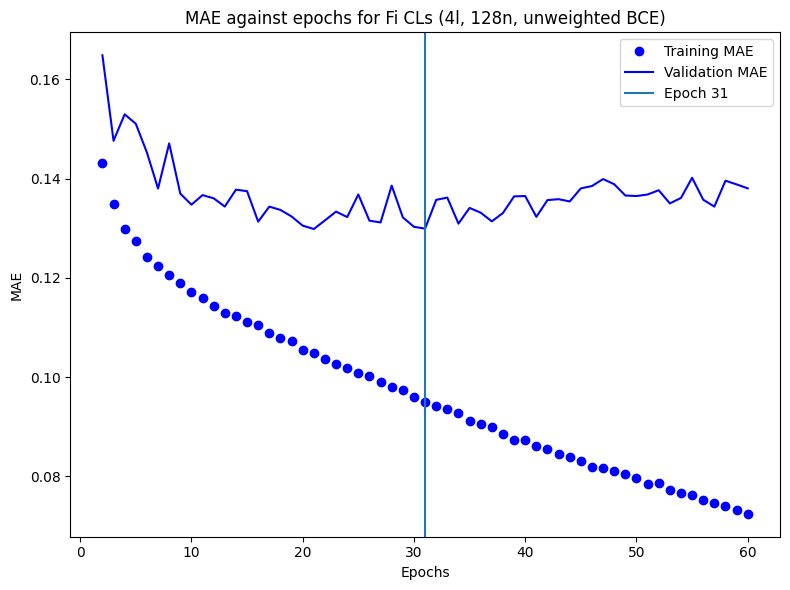

In [22]:
# Plot training and validation accuracy for each epoch

best_epoch = 31
cut = 1
epochs = range(cut+1, num_epochs + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training MAE")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation MAE")
plt.axvline(best_epoch, label=f"Epoch {best_epoch}")
#plt.axhline(0.1115)
plt.title(f"MAE against epochs for {chosen_CLs[:-8]} CLs (4l, 128n, unweighted BCE)")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
#plt.savefig(f"../plots/fitting_different_CLs/training_info_{chosen_CLs[:-8]}.png")
plt.show()

In [25]:
# Train new model on all of the available data

df = pd.read_csv("../csv-files/Bino-DM-norm-inputs-train.csv")
labels = df.pop(chosen_CLs)
train = df[training_cols[:-1]]

model = build_model()

history = model.fit(
    train,
    labels,
    epochs=best_epoch, # Change this depending on when the model starts overfitting
    verbose=0
)

In [4]:
df = pd.read_csv("../csv-files/EWKino_CLs_train.csv")
df.shape

(10438, 13)

In [ ]:
"""
This is the code block for storing predictions and targets alone in separate dataframe
# Read in the test file that the model has not seen
test = pd.read_csv("csv-files/EWKino_Is_Valid_test.csv")

# Store the ground truth we are hoping to predict in targets
targets = test.pop("Is_Valid").values

data = {'Targets': targets,
        'Predictions': predictions}
"""

# This code reads in test dataframe, use trained model to predict value of interest, and store the predicted values and original targets
test_df = pd.read_csv("../csv-files/Bino-DM-norm-inputs-test.csv")
model_input = test_df[input_parameters[:-1]]

# Create copy so we are not editing original df
test_df_plus_predictions = test_df.copy()

# Load in a previously created model here if needed
model = tf.keras.models.load_model('../models/Bino_model_4l_128n_31e.keras')

# Predict the DM relic densities using our model. Using .flatten() turns predictions into a 1D array that can be put into a dataframe
predictions = model.predict(model_input).flatten()
targets = test_df[chosen_CLs]
test_df_plus_predictions[f'Bino_Model_Predicted_Final__CLs'] = predictions

# Save the predictions of the model
#test_df_plus_predictions.to_csv("../csv-files/CLs_predictions/EWKino_and_Bino_Model_predictions_with_all_data.csv", index=False)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [17]:
df = pd.read_csv("../csv-files/Bino-DM.csv")
df.shape

/tmp/ipykernel_2280/1187176189.py:1: DtypeWarning: Columns (237,239,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../csv-files/Bino-DM.csv")


(8897, 244)

/tmp/ipykernel_2280/2228876550.py:34: RuntimeWarning: invalid value encountered in divide
  ratio = total_rejections / incorrect_rejections


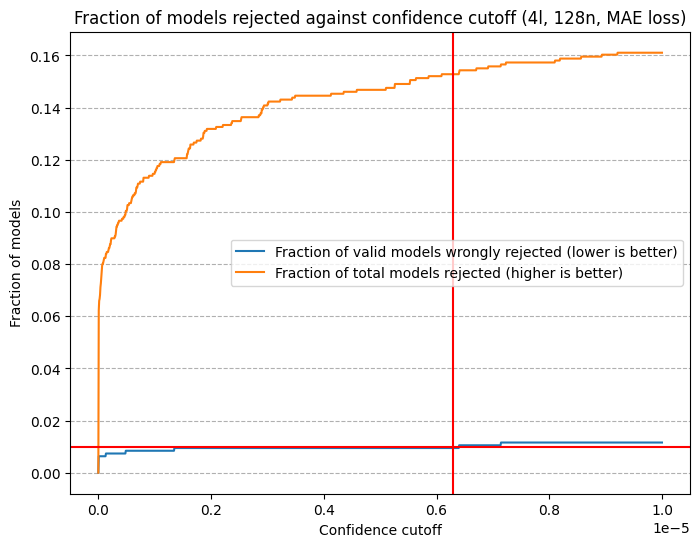

In [14]:
def plot_rejections_by_cutoff(true_values, predicted_values, num_points=100, x_range=1, save=False):

    # Calculate which models should be rejected (CLs < 0.05, which also selects Is_Valid == 0)
    true_cutoff = 0.05
    target_rejections = true_values < true_cutoff
    correct_accepted = np.logical_not(target_rejections)
    
    # Create array of test cutoffs
    test_cutoffs = np.linspace(0,x_range,num=num_points)
 
    # Create array of incorrect rejection
    incorrect_rejections = []
    total_rejections = []
    ratio = []

    for cutoff in test_cutoffs:

        # Calculate which predictions are rejected by chosen cutoff
        rejected_predictions = predicted_values < cutoff
        
        # Calculate fraction of models that should have been accepted but were rejected
        total_wrongly_rejected = (rejected_predictions > target_rejections).sum()
        fraction_wrongly_rejected = total_wrongly_rejected / correct_accepted.sum()
        
        # Calculate fraction of all models rejected
        fraction_rejeceted = rejected_predictions.sum() / len(true_values)
        
        # Store these values for plotting
        incorrect_rejections.append(fraction_wrongly_rejected)
        total_rejections.append(fraction_rejeceted)
        
    incorrect_rejections = np.array(incorrect_rejections)
    total_rejections = np.array(total_rejections)
    ratio = total_rejections / incorrect_rejections
    ratio = ratio / 400
    
    # Plot fraction of rejected models against cutoff
    plt.figure(figsize=(8, 6))
    plt.plot(test_cutoffs, incorrect_rejections)
    plt.plot(test_cutoffs, total_rejections)
    
    #plt.plot(test_cutoffs, ratio)
    
    plt.axhline(0.01, color="red")
    #plt.axhline(0.095, color="red")
    plt.axvline(0.63e-5, color='red')
    plt.xlabel("Confidence cutoff")
    plt.ylabel("Fraction of models")
    plt.grid(axis='y', linestyle='--')
    plt.legend(["Fraction of valid models wrongly rejected (lower is better)", "Fraction of total models rejected (higher is better)"])
    plt.title("Fraction of models rejected against confidence cutoff (4l, 128n, MAE loss)")
    
    if save == True:
        plt.savefig(f"../plots/fitting_different_CLs/{chosen_CLs[:-8]}.png")
        
    plt.show()
    
plot_rejections_by_cutoff(targets, predictions, len(targets), 0.00001, save=False)